# DSSC Geometry and Calibration

In this example, we will show you how to assemble the modules of the DSSC detector into a single image and then apply offset and intra-dark corrections.

In [1]:
import multiprocessing as mp
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from extra_data import RunDirectory, stack_detector_data
from pyfoamalgo.geometry import DSSC_1MGeometry
from pyfoamalgo import correct_image_data, nanmean

mp.cpu_count()

80

In [2]:
run = RunDirectory("/gpfs/exfel/exp/XMPL/201750/p700000/raw/r0024")

run.info()

# of trains:    10948
Duration:       0:18:14.8
First train ID: 517723259
Last train ID:  517734206

16 detector modules (SCS_DET_DSSC1M-1)
  e.g. module SCS_DET_DSSC1M-1 0 : 128 x 512 pixels
  SCS_DET_DSSC1M-1/DET/0CH0:xtdf
  50 frames per train, up to 547400 frames total

3 instrument sources (excluding detectors):
  - SA3_XTD10_XGM/XGM/DOOCS:output
  - SCS_BLU_XGM/XGM/DOOCS:output
  - SCS_UTC1_ADQ/ADC/1:network

20 control sources: (1 entry per train)
  - P_GATT
  - SA3_XTD10_MONO/ENC/GRATING_AX
  - SA3_XTD10_MONO/MDL/PHOTON_ENERGY
  - SA3_XTD10_MONO/MOTOR/GRATINGS_X
  - SA3_XTD10_MONO/MOTOR/GRATING_AX
  - SA3_XTD10_MONO/MOTOR/HE_PM_X
  - SA3_XTD10_MONO/MOTOR/LE_PM_X
  - SA3_XTD10_VAC/DCTRL/AR_MODE_OK
  - SA3_XTD10_VAC/DCTRL/D12_APERT_IN_OK
  - SA3_XTD10_VAC/DCTRL/D6_APERT_IN_OK
  - SA3_XTD10_VAC/DCTRL/N2_MODE_OK
  - SA3_XTD10_VAC/GAUGE/G30470D_IN
  - SA3_XTD10_VAC/GAUGE/G30480D_IN
  - SA3_XTD10_VAC/GAUGE/G30490D_IN
  - SA3_XTD10_VAC/GAUGE/G30510C
  - SA3_XTD10_XGM/XGM/DOOCS
  - SCS

In [3]:
selected_run = run.select('*/DET/*', 'image.data')

In [4]:
_, train_data = selected_run.train_from_index(0)

## Assembling

**Note:** By passing ``real_array=False`` in the function ``stack_detector_data``, it actually returns an array-like wrapper around the existing arrays. Otherwise, the data will be copied which can be time-consuming.

In [5]:
# Stack the detector modules into a single array.
modules_data = stack_detector_data(train_data, 'image.data', real_array=False)
# There is an additional axis for raw data.
modules_data = modules_data.squeeze(axis=1)

modules_data.shape, modules_data.dtype

((50, 16, 128, 512), dtype('uint16'))

In [6]:
# Create the geometry with a geometry file and quadrant positions.
quad_pos = [[-124.100,    3.112],
            [-133.068, -110.604],
            [   0.988, -125.236],
            [   4.528,   -4.912]]  # mm
geom = DSSC_1MGeometry.from_h5_file_and_quad_positions('dssc_geo_june19.h5', quad_pos)

In [7]:
n_pulses = modules_data.shape[0]

# Allocate the assembled image array and reuse it as far as possible to speed up data processing.
assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,), dtype=np.float32)
assembled.shape

(50, 1196, 1096)

In [8]:
t0 = time.perf_counter()

geom.position_all_modules(modules_data, out=assembled)

print(f"Assembling a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Assembling a train with 50 pulses takes: 15.9 ms


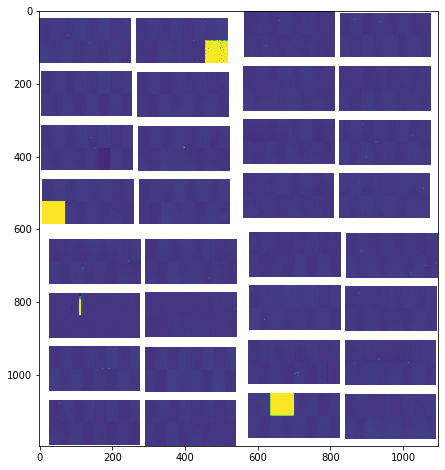

In [9]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled[0], vmin=0, vmax=256)

## Offset correction

In [10]:
# Since we do not have a corresponding dark dataset, we use the data in another train as a mock dark.
_, train_data = selected_run.train_from_index(1)

dark_modules = stack_detector_data(train_data, 'image.data', real_array=False).squeeze(axis=1)
dark_assembled = geom.output_array_for_position_fast(extra_shape=(n_pulses,), dtype=np.float32)

geom.position_all_modules(dark_modules, out=dark_assembled)

**Note:** By passing `detector='DSSC'`, values of pixels in `assembled` will be corrected to 256 if it is 0, before applying the offset subtraction.

In [11]:
t0 = time.perf_counter()

correct_image_data(assembled, offset=dark_assembled, detector='DSSC')

print(f"Applying offset correction to a train with {n_pulses} pulses takes: "
      f"{1e3 * (time.perf_counter() - t0):.1f} ms")

Applying offset correction to a train with 50 pulses takes: 22.7 ms


**Note:** `nanmean` implemented in `pyfoamalgo` is much faster than `numpy.nanmean`.

In [12]:
t0 = time.perf_counter()

# Calculate the average (taking into account nan) of the assembled image.
assembled_mean = nanmean(assembled, axis=0)

print(f"Averaging a train with {n_pulses} pulses takes: {1e3 * (time.perf_counter() - t0):.1f} ms")

Averaging a train with 50 pulses takes: 12.4 ms


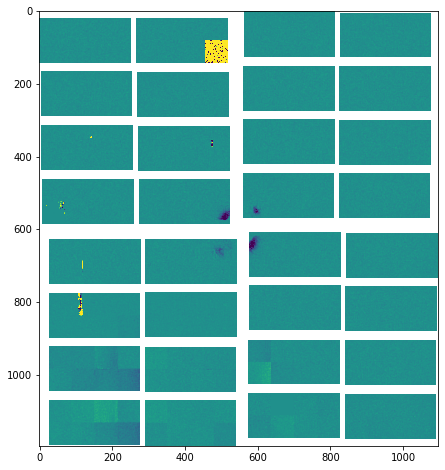

In [13]:
_, ax = plt.subplots(figsize=(8, 8))

ax.imshow(assembled_mean, vmin=-1, vmax=1)

## Intra-dark correction

For every other image in the array starting from the first one, it will be subtracted by the image next to it.

Indeed, one can apply all the corrections with a single function call:

```Python
correct_image_data(assembled, offset=dark_assembled, intra_dark=True, detector='DSSC')
```

In [14]:
t0 = time.perf_counter()

correct_image_data(assembled, intradark=True)

print(f"Applying intra-dark correction to a train with {n_pulses} pulses takes: "
      f"{1e3 * (time.perf_counter() - t0):.1f} ms")

Applying intra-dark correction to a train with 50 pulses takes: 10.4 ms


Text(0.5, 1.0, 'Without intra-dark correction')

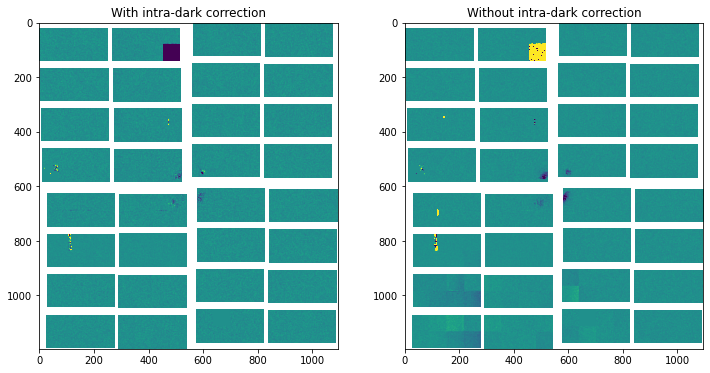

In [15]:
_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(nanmean(assembled[::2], axis=0), vmin=-1, vmax=1)
ax[0].set_title("With intra-dark correction")
ax[1].imshow(nanmean(assembled[1::2], axis=0), vmin=-1, vmax=1)
ax[1].set_title("Without intra-dark correction")